<a href="https://colab.research.google.com/github/Polina444/ml-cource_hw/blob/main/Lab2_DL_part3_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

from IPython.display import clear_output
import matplotlib.pyplot as plt


import numpy as np
import IPython.display as display
from tqdm import tqdm


import torch, torch.nn as nn
import torch.nn.functional as F


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
#if not os.path.exists('sonnets.txt'):
    #!wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

#with open('/home/polina/Загрузки/sonnets.txt', 'r') as iofile:
    #text = iofile.readlines()

from google.colab import files

uploaded = files.upload()

filename = next(iter(uploaded))
with open(filename, 'r') as file:
    text = file.readlines()


TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

Saving sonnets.txt to sonnets.txt


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
#text = ''.join(text).lower()
#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
#assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
#print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [ ]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

#with open('onegin.txt', 'r') as iofile:
    #text = iofile.readlines()

#text = [x.replace('\t\t', '') for x in text]
#text = ''.join(text).lower()
#print(text[0:500])
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]


--2023-12-23 15:24:19--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-12-23 15:24:19 (7.78 MB/s) - ‘onegin.txt’ saved [262521/262521]



In [3]:
text[0:50]

['  From fairest creatures we desire increase,\n',
 "  That thereby beauty's rose might never die,\n",
 '  But as the riper should by time decease,\n',
 '  His tender heir might bear his memory:\n',
 '  But thou, contracted to thine own bright eyes,\n',
 "  Feed'st thy light's flame with self-substantial fuel,\n",
 '  Making a famine where abundance lies,\n',
 '  Thy self thy foe, to thy sweet self too cruel:\n',
 "  Thou that art now the world's fresh ornament,\n",
 '  And only herald to the gaudy spring,\n',
 '  Within thine own bud buriest thy content,\n',
 "  And tender churl mak'st waste in niggarding:\n",
 '    Pity the world, or else this glutton be,\n',
 "    To eat the world's due, by the grave and thee.\n",
 '\n',
 '  II\n',
 '\n',
 '  When forty winters shall besiege thy brow,\n',
 "  And dig deep trenches in thy beauty's field,\n",
 "  Thy youth's proud livery so gazed on now,\n",
 "  Will be a tatter'd weed of small worth held:\n",
 '  Then being asked, where all thy beaut

In [4]:
text = [line for line in text if line != '\n']

In [5]:
text[0:50]

['  From fairest creatures we desire increase,\n',
 "  That thereby beauty's rose might never die,\n",
 '  But as the riper should by time decease,\n',
 '  His tender heir might bear his memory:\n',
 '  But thou, contracted to thine own bright eyes,\n',
 "  Feed'st thy light's flame with self-substantial fuel,\n",
 '  Making a famine where abundance lies,\n',
 '  Thy self thy foe, to thy sweet self too cruel:\n',
 "  Thou that art now the world's fresh ornament,\n",
 '  And only herald to the gaudy spring,\n',
 '  Within thine own bud buriest thy content,\n',
 "  And tender churl mak'st waste in niggarding:\n",
 '    Pity the world, or else this glutton be,\n',
 "    To eat the world's due, by the grave and thee.\n",
 '  II\n',
 '  When forty winters shall besiege thy brow,\n',
 "  And dig deep trenches in thy beauty's field,\n",
 "  Thy youth's proud livery so gazed on now,\n",
 "  Will be a tatter'd weed of small worth held:\n",
 '  Then being asked, where all thy beauty lies,\n',
 '

In [6]:
import re

text = [line for line in text if not re.match(r'^[IVXLCDM]+$', line)]
text = [re.sub(r'["\’«…:»\u2014\u2013]', '', line) for line in text]

In [7]:
text[0:50]

['  From fairest creatures we desire increase,\n',
 "  That thereby beauty's rose might never die,\n",
 '  But as the riper should by time decease,\n',
 '  His tender heir might bear his memory\n',
 '  But thou, contracted to thine own bright eyes,\n',
 "  Feed'st thy light's flame with self-substantial fuel,\n",
 '  Making a famine where abundance lies,\n',
 '  Thy self thy foe, to thy sweet self too cruel\n',
 "  Thou that art now the world's fresh ornament,\n",
 '  And only herald to the gaudy spring,\n',
 '  Within thine own bud buriest thy content,\n',
 "  And tender churl mak'st waste in niggarding\n",
 '    Pity the world, or else this glutton be,\n',
 "    To eat the world's due, by the grave and thee.\n",
 '  II\n',
 '  When forty winters shall besiege thy brow,\n',
 "  And dig deep trenches in thy beauty's field,\n",
 "  Thy youth's proud livery so gazed on now,\n",
 "  Will be a tatter'd weed of small worth held\n",
 '  Then being asked, where all thy beauty lies,\n',
 '  Wh

In [8]:
text = [line.lower() for line in text]
text = [x.strip() + "\n" for x in text]
text = [x for x in text if len(x) >= 30]

In [9]:
text[0:50]

['from fairest creatures we desire increase,\n',
 "that thereby beauty's rose might never die,\n",
 'but as the riper should by time decease,\n',
 'his tender heir might bear his memory\n',
 'but thou, contracted to thine own bright eyes,\n',
 "feed'st thy light's flame with self-substantial fuel,\n",
 'making a famine where abundance lies,\n',
 'thy self thy foe, to thy sweet self too cruel\n',
 "thou that art now the world's fresh ornament,\n",
 'and only herald to the gaudy spring,\n',
 'within thine own bud buriest thy content,\n',
 "and tender churl mak'st waste in niggarding\n",
 'pity the world, or else this glutton be,\n',
 "to eat the world's due, by the grave and thee.\n",
 'when forty winters shall besiege thy brow,\n',
 "and dig deep trenches in thy beauty's field,\n",
 "thy youth's proud livery so gazed on now,\n",
 "will be a tatter'd weed of small worth held\n",
 'then being asked, where all thy beauty lies,\n',
 'where all the treasure of thy lusty days;\n',
 'to say, w

In [10]:
translator = str.maketrans('', '', string.punctuation)
text= [line.translate(translator) for line in text]

In [11]:
text[0:50]

['from fairest creatures we desire increase\n',
 'that thereby beautys rose might never die\n',
 'but as the riper should by time decease\n',
 'his tender heir might bear his memory\n',
 'but thou contracted to thine own bright eyes\n',
 'feedst thy lights flame with selfsubstantial fuel\n',
 'making a famine where abundance lies\n',
 'thy self thy foe to thy sweet self too cruel\n',
 'thou that art now the worlds fresh ornament\n',
 'and only herald to the gaudy spring\n',
 'within thine own bud buriest thy content\n',
 'and tender churl makst waste in niggarding\n',
 'pity the world or else this glutton be\n',
 'to eat the worlds due by the grave and thee\n',
 'when forty winters shall besiege thy brow\n',
 'and dig deep trenches in thy beautys field\n',
 'thy youths proud livery so gazed on now\n',
 'will be a tatterd weed of small worth held\n',
 'then being asked where all thy beauty lies\n',
 'where all the treasure of thy lusty days\n',
 'to say within thine own deep sunken eyes

In [12]:
def process_batch(batch):
    len_set = set(len(s) for s in batch)
    if len(len_set) > 1:
        flag = True
    else:
        flag = False

    combined_string = ''.join(batch)

    total_chars = len(combined_string)
    num_strings = len(batch)
    avg_len = total_chars // num_strings
    remainder = total_chars % num_strings
    if remainder > 0:
        avg_len += 1

    batch = [combined_string[i:i+avg_len] for i in range(0, total_chars, avg_len)]

    return batch

In [13]:
test= ['аfj,dfgb,sjhgr','hdfsh','dh,f,s']

test= process_batch(test)
print(test)


['аfj,dfgb,', 'sjhgrhdfs', 'hdh,f,s']


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
#text = " ".join(line.lower() for line in text)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [14]:
tokens = set()

for x in text:
    tokens.update(set(x))

print(tokens)
print(len(tokens))

{'o', 'd', 'y', 'm', 'l', 'c', 'f', 'n', 'g', 'k', 'h', 'v', '\n', 'b', 'x', 'r', 'a', 'p', 't', ' ', 'j', 'i', 'z', 'e', 'w', 'u', 's', 'q'}
28


In [15]:
PAD = '_'
tokens.add(PAD)
tokens = sorted(list(tokens))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [16]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

In [17]:
assert np.all(x == idx_to_token[token_to_idx[x]] for x in token_to_idx)

In [18]:
def create_matrix(lines, max_len=None, pad=PAD, dtype='int32', batch_first=True):
  max_len = max_len or max(map(len, lines))
  matrix = np.zeros([len(lines), max_len], dtype) + token_to_idx[PAD]

  for i, line in enumerate(lines):
    line_indices = [token_to_idx[token] if token != PAD else token_to_idx[PAD] for token in line]
    matrix[i, :len(line_indices)] = line_indices
    if not batch_first:
      matrix = np.transpose(matrix)

  return matrix

In [19]:
create_matrix(text[1:5])

array([[22, 10,  3, 22,  1, 22, 10,  7, 20,  7,  4, 27,  1,  4,  7,  3,
        23, 22, 27, 21,  1, 20, 17, 21,  7,  1, 15, 11,  9, 10, 22,  1,
        16,  7, 24,  7, 20,  1,  6, 11,  7,  0,  2,  2,  2],
       [ 4, 23, 22,  1,  3, 21,  1, 22, 10,  7,  1, 20, 11, 18,  7, 20,
         1, 21, 10, 17, 23, 14,  6,  1,  4, 27,  1, 22, 11, 15,  7,  1,
         6,  7,  5,  7,  3, 21,  7,  0,  2,  2,  2,  2,  2],
       [10, 11, 21,  1, 22,  7, 16,  6,  7, 20,  1, 10,  7, 11, 20,  1,
        15, 11,  9, 10, 22,  1,  4,  7,  3, 20,  1, 10, 11, 21,  1, 15,
         7, 15, 17, 20, 27,  0,  2,  2,  2,  2,  2,  2,  2],
       [ 4, 23, 22,  1, 22, 10, 17, 23,  1,  5, 17, 16, 22, 20,  3,  5,
        22,  7,  6,  1, 22, 17,  1, 22, 10, 11, 16,  7,  1, 17, 25, 16,
         1,  4, 20, 11,  9, 10, 22,  1,  7, 27,  7, 21,  0]], dtype=int32)

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [21]:
MAX_PHRASE = 100
num_tokens=len(tokens)

text1 = "\n".join(text)
text11 = [text1[i:i+MAX_PHRASE] for i in range(len(text1) - MAX_PHRASE)]

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [22]:
class RNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, states):
        h_seq, next_states = self.rnn(self.emb(x), states)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, next_states

    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=False)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

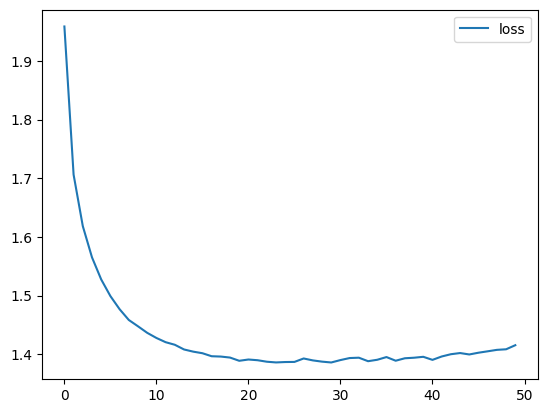

Total: 100%|██████████| 50/50 [04:57<00:00,  5.94s/it]


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_rnn = RNN(num_tokens, emb_size=64, rnn_num_units=256)
model_rnn = model_rnn.to(device)
optimazer_rnn = torch.optim.Adam(model_rnn.parameters())
loss_function = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])

batch_size= 64
num_epochs =50
lr_scheduler=None
progress_bar = tqdm(range(num_epochs), desc='Total')
history = []
states = model_rnn.initial_state(batch_size)
for i in progress_bar:
    epoch_loss = []
    for bi in range(0, len(text11), batch_size):
        batch = text11[bi:bi+batch_size]
        if len(batch) != batch_size:
            continue
        batch_ix = create_matrix(batch)
        batch_ix = torch.LongTensor(batch_ix).to(device)
        states = states.to(device)
        logits_seq, states = model_rnn(batch_ix, states)
        states = states.detach()
        predictions_logits = logits_seq[:-1]
        actual_next_tokens = batch_ix[1:]
        loss = loss_function(
            predictions_logits.reshape((-1, num_tokens)),
            actual_next_tokens.reshape(-1)
        )
        loss.backward()
        optimazer_rnn.step()
        optimazer_rnn.zero_grad()
        epoch_loss.append(loss.item())
    if lr_scheduler is not None:
        lr_scheduler.step(loss)
    history.append(np.mean(epoch_loss))
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()


In [ ]:
last_loss = history[-1]
print(last_loss)

In [55]:

def generate_text(model, seed_phrase='you', max_length=100, temperature=1.0):
    seq = []
    for token in seed_phrase:
      seq.append(token_to_idx[token])
    phrase = torch.LongTensor(seq)
    seq = torch.LongTensor([seq]).to(device)

    states = model.initial_state(1).to(device)
    logits_seq, states = model(seq, states)
    logits_next = logits_seq[-1]

    softmax = nn.Softmax()

    #start generating
    for _ in range(max_length - len(seed_phrase)):

        p_next = softmax(logits_next / temperature)[-1]
        # print('p_next.shape =', p_next.shape)

        next_token = np.random.choice(len(tokens), p=p_next.cpu().detach().numpy())
        phrase = torch.cat([phrase, torch.tensor([next_token])])
        next_token = [[next_token]]
        next_token = torch.LongTensor(next_token)
        next_token = next_token.to(device)

        logits_seq, states = model(next_token, states)  # <-- here we call your one-step code
        logits_next = logits_seq[-1]

    return ''.join([tokens[ix] for ix in phrase]) #.data.numpy()[0]])

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


In [56]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'temperature = {temp}, text:')
    print(generate_text(model_rnn, seed_phrase='you', max_length=50, temperature=temp) + '\n')

temperature = 0.1, text:
your can strange of thee a believe heart thee a be

temperature = 0.2, text:
you bright thee mine eye but sweet fresh her bring

temperature = 0.5, text:
your be faults and fall the beauty hath thy fairis

temperature = 1.0, text:
your outhing my love friend faults conscate

if th

temperature = 2.0, text:
your wouldd
aniwlargy true migess
byathoh powain b



### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [32]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, state_seq=None):
        if state_seq is None:
            state_seq = self.initial_state()
        h_seq, state_seq = self.rnn(self.emb(x), state_seq)
        next_logits = self.hid_to_logits(h_seq)

        return next_logits, state_seq

    def initial_state(self, batch_size):
        h = c = torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)
        init_state = (h, c)
        return init_state

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

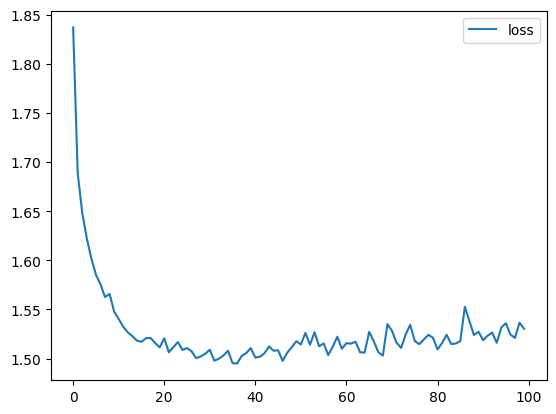

Total: 100%|██████████| 100/100 [21:13<00:00, 12.73s/it]


In [52]:
model_lstm = LSTM(emb_size=64, rnn_num_units=256)
model_lstm = model_lstm.to(device)

optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=8e-3)
lr_sсheduler = torch.optim.lr_scheduler.StepLR(optimizer_lstm, step_size=100, gamma=0.7)
loss_function = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])

history = []
batch_size= 64
#num_epochs =50

progress_bar = tqdm(range(100), desc='Total')
h, c = model_lstm.initial_state(batch_size)


for i in progress_bar:
  epoch_loss = []

  for bi in range(0, len(text11), batch_size):
    batch = text11[bi:bi + batch_size]
    if len(batch) != batch_size:
      continue

    process_batch(batch)
    batch_ix = create_matrix(batch)
    batch_ix = torch.LongTensor(batch_ix)
    batch_ix = batch_ix.to(device)
    h = h.to(device)
    c = c.to(device)

    logits_seq, (h, c) = model_lstm(batch_ix, (h, c))
    h = h.detach()
    c = c.detach()

    predictions_logits = logits_seq[:-1]
    actual_next_tokens = batch_ix[1:]

    loss = loss_function(predictions_logits.reshape((-1, num_tokens)), actual_next_tokens.reshape(-1))
    loss.backward()
    optimizer_lstm.step()
    optimizer_lstm.zero_grad()
    epoch_loss.append(loss.item())

  if lr_scheduler is not None:
        lr_scheduler.step(loss)
  history.append(np.mean(epoch_loss))
  if (i + 1) % 5 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()


In [ ]:
last_loss = history[-1]
print(last_loss)

In [53]:

def generate_text_2(model, seed_phrase='hello, ', max_length=150, temperature=1.0):
    seq = []
    for token in seed_phrase:
      seq.append(token_to_idx[token])
    phrase = torch.LongTensor(seq)
    seq = torch.LongTensor([seq]).to(device)

    h, c = model.initial_state(1)
    h, c = h.to(device), c.to(device)
    logits_seq, (h, c) = model(seq, (h, c))
    logits_next = logits_seq[-1]

    softmax = nn.Softmax()

    for _ in range(max_length - len(seed_phrase)):

        p_next = softmax(logits_next / temperature)[-1]

        next_token = np.random.choice(len(tokens), p=p_next.cpu().detach().numpy())
        phrase = torch.cat([phrase, torch.tensor([next_token])])
        next_token = [[next_token]]
        next_token = torch.LongTensor(next_token)
        next_token = next_token.to(device)

        logits_seq, (h, c) = model(next_token, (h, c))
        logits_next = logits_seq[-1]

    return ''.join([tokens[ix] for ix in phrase])

In [54]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'temperature = {temp}, text:', generate_text_2(model_lstm, seed_phrase='love ', max_length=70, temperature= temp) + '\n\n')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


temperature = 0.1, text: love the be the breath the be the see the lies

and the be the but the


temperature = 0.2, text: love the breath a self the strange

and the be the for thee

and the b


temperature = 0.5, text: love i by my boit fair tongue stand

ah the have may and afiticuat i b


temperature = 1.0, text: love my fall deatht tacts dwakenon

sinces of jumpstrike head thy made


temperature = 2.0, text: love hapf amplyinslileuiudds brand
touthtehs torrposedusy make

a eest




### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [61]:
# Saving and loading code here

path = 'saved.pt'

torch.save(model_lstm.state_dict(), path)

new = LSTM(emb_size=64, rnn_num_units=256)
new.load_state_dict(torch.load(path))
new = new.to(device)


print(generate_text_2(new, seed_phrase='love', max_length=200, temperature=0.2))

love the bright the be the breath for thee

and the do i not be the see the do i not be the breath the be made the by i but the for thee

this i sweet the bright

and the be the but the be the bright 


Выводы: Модель LSTM показала себя лучше, на мой взгляд.
Для RNN:
При temperature = 0.1 генерируемый текст имеет повторяющиеся фразы и мало разнообразия. Это может быть связано с тем, что при очень низкой температуре модель выбирает наиболее вероятные следующие символы, что приводит к повторениям.

При temperature = 0.2 текст становится немного более разнообразным, но всё ещё сохраняет некоторую структуру и смысл. Например, "you bright thee mine eye but sweet fresh her bring".

При temperature = 0.5 генерируемый текст становится ещё более разнообразным и содержит более осмысленные фразы. Например, "your be faults and fall the beauty hath thy fairis".

При temperature = 1.0 текст становится ещё более разнообразным и более свободным от ограничений. Однако, это также может привести к более нелогичным или несвязанным фразам. Например, "your outhing my love friend faults conscate if th".

При temperature = 2.0 генерируемый текст становится очень разнообразным, но также может быть менее связным и менее осмысленным. Например, "your wouldd aniwlargy true migess byathoh powain b".

Для LSTM аналогично.

В обоих моделях наблюдается тренд, что с увеличением temperature генерируемый текст становится более разнообразным и менее связанным.

Итоговый текст получися читаемым и в какой-то мере даже похож  на  осмысленный стих


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)